In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
import xgboost
from sklearn.model_selection import GroupKFold, GridSearchCV

# I don't like SettingWithCopyWarnings ...
warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline

### 1.Get the extracted data

In [2]:
train = pd.read_csv('data/extracted_fields_train.gz', 
                    dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
test = pd.read_csv('data/extracted_fields_test.gz', 
                   dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
train.shape, test.shape

((903653, 30), (804684, 30))

### 2.Data Fold using GroupKfold

In [3]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

### 3.Target Define transaction

In [4]:
y_reg = train['totals.transactionRevenue'].fillna(0)
del train['totals.transactionRevenue']

if 'totals.transactionRevenue' in test.columns:
    del test['totals.transactionRevenue']

### 4.Add date features

Only add the one I think can ganeralize

In [5]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent',
       'trafficSource.campaign', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source'],
      dtype='object')

In [6]:
for df in [train, test]:
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['date'].dt.dayofweek
    df['sess_date_hours'] = df['date'].dt.hour
    df['sess_date_dom'] = df['date'].dt.day

# more Complex feature engineering

In [7]:
# https://www.kaggle.com/prashantkikani/teach-lightgbm-to-sum-predictions-fe
def browser_mapping(x):
    browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
    if x in browsers:
        return x.lower()
    elif  ('android' in x) or ('samsung' in x) or ('mini' in x) or ('iphone' in x) or ('in-app' in x) or ('playstation' in x):
        return 'mobile browser'
    elif  ('mozilla' in x) or ('chrome' in x) or ('blackberry' in x) or ('nokia' in x) or ('browser' in x) or ('amazon' in x):
        return 'mobile browser'
    elif  ('lunascape' in x) or ('netscape' in x) or ('blackberry' in x) or ('konqueror' in x) or ('puffin' in x) or ('amazon' in x):
        return 'mobile browser'
    elif '(not set)' in x:
        return x
    else:
        return 'others'
    
    
def adcontents_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('placement' in x) | ('placememnt' in x):
        return 'placement'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'ad' in x:
        return 'ad'
    else:
        return 'others'
    
def source_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('youtube' in x):
        return 'youtube'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'yahoo' in x:
        return 'yahoo'
    elif 'facebook' in x:
        return 'facebook'
    elif 'reddit' in x:
        return 'reddit'
    elif 'bing' in x:
        return 'bing'
    elif 'quora' in x:
        return 'quora'
    elif 'outlook' in x:
        return 'outlook'
    elif 'linkedin' in x:
        return 'linkedin'
    elif 'pinterest' in x:
        return 'pinterest'
    elif 'ask' in x:
        return 'ask'
    elif 'siliconvalley' in x:
        return 'siliconvalley'
    elif 'lunametrics' in x:
        return 'lunametrics'
    elif 'amazon' in x:
        return 'amazon'
    elif 'mysearch' in x:
        return 'mysearch'
    elif 'qiita' in x:
        return 'qiita'
    elif 'messenger' in x:
        return 'messenger'
    elif 'twitter' in x:
        return 'twitter'
    elif 't.co' in x:
        return 't.co'
    elif 'vk.com' in x:
        return 'vk.com'
    elif 'search' in x:
        return 'search'
    elif 'edu' in x:
        return 'edu'
    elif 'mail' in x:
        return 'mail'
    elif 'ad' in x:
        return 'ad'
    elif 'golang' in x:
        return 'golang'
    elif 'direct' in x:
        return 'direct'
    elif 'dealspotr' in x:
        return 'dealspotr'
    elif 'sashihara' in x:
        return 'sashihara'
    elif 'phandroid' in x:
        return 'phandroid'
    elif 'baidu' in x:
        return 'baidu'
    elif 'mdn' in x:
        return 'mdn'
    elif 'duckduckgo' in x:
        return 'duckduckgo'
    elif 'seroundtable' in x:
        return 'seroundtable'
    elif 'metrics' in x:
        return 'metrics'
    elif 'sogou' in x:
        return 'sogou'
    elif 'businessinsider' in x:
        return 'businessinsider'
    elif 'github' in x:
        return 'github'
    elif 'gophergala' in x:
        return 'gophergala'
    elif 'yandex' in x:
        return 'yandex'
    elif 'msn' in x:
        return 'msn'
    elif 'dfa' in x:
        return 'dfa'
    elif '(not set)' in x:
        return '(not set)'
    elif 'feedly' in x:
        return 'feedly'
    elif 'arstechnica' in x:
        return 'arstechnica'
    elif 'squishable' in x:
        return 'squishable'
    elif 'flipboard' in x:
        return 'flipboard'
    elif 't-online.de' in x:
        return 't-online.de'
    elif 'sm.cn' in x:
        return 'sm.cn'
    elif 'wow' in x:
        return 'wow'
    elif 'baidu' in x:
        return 'baidu'
    elif 'partners' in x:
        return 'partners'
    else:
        return 'others'

train['device.browser'] = train['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
train['trafficSource.adContent'] = train['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
train['trafficSource.source'] = train['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

test['device.browser'] = test['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
test['trafficSource.adContent'] = test['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
test['trafficSource.source'] = test['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

def process_device(data_df):
    print("process device ...")
    data_df['source.country'] = data_df['trafficSource.source'] + '_' + data_df['geoNetwork.country']
    data_df['campaign.medium'] = data_df['trafficSource.campaign'] + '_' + data_df['trafficSource.medium']
    data_df['browser.category'] = data_df['device.browser'] + '_' + data_df['device.deviceCategory']
    data_df['browser.os'] = data_df['device.browser'] + '_' + data_df['device.operatingSystem']
    return data_df

train = process_device(train)
test = process_device(test)

def custom(data):
    print('custom..')
    data['device_deviceCategory_channelGrouping'] = data['device.deviceCategory'] + "_" + data['channelGrouping']
    data['channelGrouping_browser'] = data['device.browser'] + "_" + data['channelGrouping']
    data['channelGrouping_OS'] = data['device.operatingSystem'] + "_" + data['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            data[i + "_" + j] = data[i] + "_" + data[j]
    
    data['content.source'] = data['trafficSource.adContent'] + "_" + data['source.country']
    data['medium.source'] = data['trafficSource.medium'] + "_" + data['source.country']
    return data
train = custom(train)
test = custom(test)

process device ...
process device ...
custom..
custom..


### 5.Create features list

In [8]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime'
]

categorical_features = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]

### 6.Factorize categoricals

In [9]:
for f in categorical_features:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

In [10]:
train.shape, test.shape

((903653, 69), (804684, 69))

### 7.Cross Validation for Hyperparameter Tuning

In [11]:
params={'learning_rate': 0.03,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        "subsample": 0.99,
        "colsample_bytree": 0.99,
        "random_state":42,
        'max_depth': 15,
        'lambda_l2': 0.02085548700474218,
        'lambda_l1': 0.004107624022751344,
        'bagging_fraction': 0.7934712636944741,
        'feature_fraction': 0.686612409641711,
        'min_child_samples': 21
       }


### 8.Model Training with Kfold Validation LightGBM

In [12]:
train_features = [_f for _f in train.columns if _f not in excluded_features]

In [13]:
#train_features_selected = [_f for _f in train_features if _f in selected_features]

In [14]:
#len(train_features_selected), len(train_features_excl), len(excluded_features)

In [15]:
folds = get_folds(df=train, n_splits=5)

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    print("Fold:",fold_)
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    reg = lgb.LGBMRegressor(**params,
         n_estimators=1000
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

Fold: 0
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.66877
[200]	valid_0's rmse: 1.64753
[300]	valid_0's rmse: 1.64346
[400]	valid_0's rmse: 1.64096
[500]	valid_0's rmse: 1.64024
[600]	valid_0's rmse: 1.63885
[700]	valid_0's rmse: 1.6381
Early stopping, best iteration is:
[730]	valid_0's rmse: 1.63797
Fold: 1
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.6472
[200]	valid_0's rmse: 1.63055
[300]	valid_0's rmse: 1.62645
Early stopping, best iteration is:
[291]	valid_0's rmse: 1.62635
Fold: 2
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.66071
[200]	valid_0's rmse: 1.64175
[300]	valid_0's rmse: 1.63684
[400]	valid_0's rmse: 1.63443
[500]	valid_0's rmse: 1.63293
[600]	valid_0's rmse: 1.63247
Early stopping, best iteration is:
[569]	valid_0's rmse: 1.63215
Fold: 3
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.64027
[200]	valid_0's r

1.632225776776637

### 9.Display feature importances

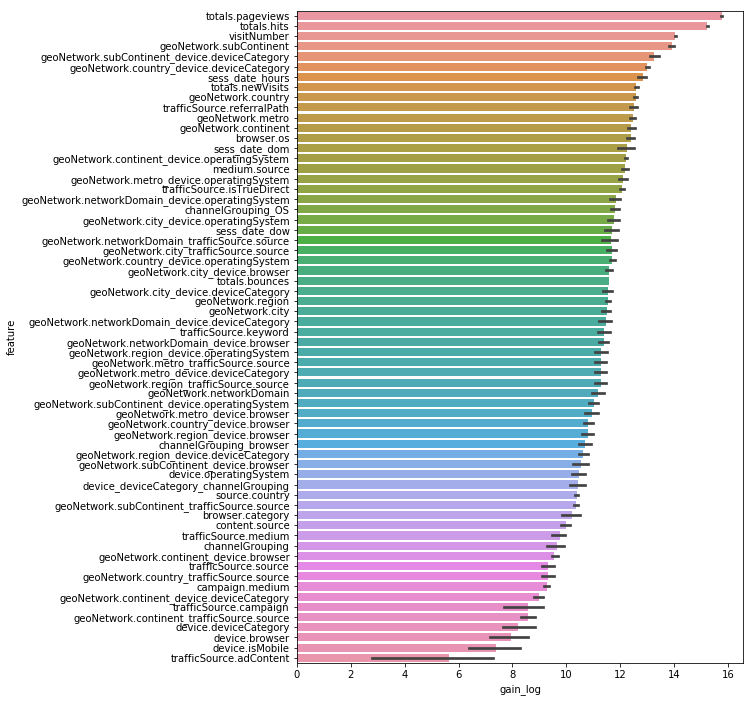

In [16]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))

### 10.Create user level predictions

In [17]:
train['predictions'] = np.expm1(oof_reg_preds)
test['predictions'] = sub_reg_preds

In [19]:
oof_reg_preds.mean()

0.23703936653080893

In [ ]:
# Aggregate data at User level
trn_data = train[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()

In [ ]:
len(trn_data.columns)

In [ ]:
%%time
# Create a list of predictions for each Visitor
trn_pred_list = train[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

In [ ]:
# Create a DataFrame with VisitorId as index
# trn_pred_list contains dict 
# so creating a dataframe from it will expand dict values into columns
trn_all_predictions = pd.DataFrame(list(trn_pred_list.values), index=trn_data.index)
trn_feats = trn_all_predictions.columns
trn_all_predictions['t_mean'] = np.log1p(trn_all_predictions[trn_feats].mean(axis=1))
trn_all_predictions['t_median'] = np.log1p(trn_all_predictions[trn_feats].median(axis=1))
trn_all_predictions['t_sum_log'] = np.log1p(trn_all_predictions[trn_feats]).sum(axis=1)
trn_all_predictions['t_sum_act'] = np.log1p(trn_all_predictions[trn_feats].fillna(0).sum(axis=1))
trn_all_predictions['t_nb_sess'] = trn_all_predictions[trn_feats].isnull().sum(axis=1)
trn_all_predictions.to_csv('trn_all_predictions.csv', index=False)
full_data = pd.concat([trn_data, trn_all_predictions], axis=1)
del trn_data, trn_all_predictions
gc.collect()
full_data.shape

In [ ]:
%%time
sub_pred_list = test[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

In [ ]:
sub_data = test[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()
sub_all_predictions = pd.DataFrame(list(sub_pred_list.values), index=sub_data.index)
for f in trn_feats:
    if f not in sub_all_predictions.columns:
        sub_all_predictions[f] = np.nan
sub_all_predictions['t_mean'] = np.log1p(sub_all_predictions[trn_feats].mean(axis=1))
sub_all_predictions['t_median'] = np.log1p(sub_all_predictions[trn_feats].median(axis=1))
sub_all_predictions['t_sum_log'] = np.log1p(sub_all_predictions[trn_feats]).sum(axis=1)
sub_all_predictions['t_sum_act'] = np.log1p(sub_all_predictions[trn_feats].fillna(0).sum(axis=1))
sub_all_predictions['t_nb_sess'] = sub_all_predictions[trn_feats].isnull().sum(axis=1)
sub_all_predictions.to_csv('sub_all_predictions.csv',index = False)
sub_full_data = pd.concat([sub_data, sub_all_predictions], axis=1)
del sub_data, sub_all_predictions
gc.collect()
sub_full_data.shape

In [ ]:
full_data.shape, sub_full_data.shape

In [ ]:
full_data.columns

### 11.Create target and Cross Validation

In [ ]:
train['target'] = y_reg
trn_user_target = train[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()

In [ ]:
params={'learning_rate': 0.03,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        "subsample": 0.99,
        "colsample_bytree": 0.99,
        "random_state":42,
        'max_depth': 15,
        'lambda_l2': 0.02085548700474218,
        'lambda_l1': 0.004107624022751344,
        'bagging_fraction': 0.7934712636944741,
        'feature_fraction': 0.686612409641711,
        'min_child_samples': 21
       }

xgb_params = {
        'objective': 'reg:linear',
        'booster': 'gbtree',
        'learning_rate': 0.02,
        'max_depth': 22,
        'min_child_weight': 57,
        'gamma' : 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 456
    }


### 12.Train a model at Visitor level

In [ ]:
'''from xgboost import XGBRegressor
folds = get_folds(df=full_data[['totals.pageviews']].reset_index(), n_splits=5)

oof_preds = np.zeros(full_data.shape[0])
oof_preds1 = np.zeros(full_data.shape[0])

both_oof = np.zeros(full_data.shape[0])
sub_preds = np.zeros(sub_full_data.shape[0])

vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = full_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = full_data.iloc[val_], trn_user_target['target'].iloc[val_]
    
    xg = XGBRegressor(**xgb_params, n_estimators=1000)
    
    reg = lgb.LGBMRegressor(**params,
        n_estimators=1500,
    )
    print('XGB' + "-" * 50)
    xg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    print('LGB' + "-" * 50)
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain_xgb'] = xg.feature_importances_ / 5
    imp_df['gain_lgb'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds1[val_] = xg.predict(val_x)
    
    oof_preds[oof_preds < 0] = 0
    oof_preds1[oof_preds1 < 0] = 0
    
    both_oof[val_] = oof_preds[val_] * 0.6 + oof_preds1[val_] * 0.4
    
    # Make sure features are in the same order
    _preds = reg.predict(sub_full_data[full_data.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    
    pre = xg.predict(sub_full_data[full_data.columns])
    pre[pre<0]=0
    
    sub_preds += (_preds / len(folds)) * 0.6 + (pre / len(folds)) * 0.4
    
print("LGB  ", mean_squared_error(np.log1p(trn_user_target['target']), oof_preds) ** .5)
print("XGB  ", mean_squared_error(np.log1p(trn_user_target['target']), oof_preds1) ** .5)
print("Combine  ", mean_squared_error(np.log1p(trn_user_target['target']), both_oof) ** .5)'''

In [ ]:
#selected_features.append('hits_per_pageviews')

In [ ]:
full_data_no_zero_columns = [_f for _f in full_data.columns if _f in selected_features] 

In [ ]:
full_data_no_zero_features = full_data[full_data_no_zero_columns]

In [ ]:
sub_full_data_no_zero_columns = [_f for _f in sub_full_data.columns if _f in selected_features]

In [ ]:
sub_full_data_no_zero_features = sub_full_data[sub_full_data_no_zero_columns]

In [ ]:
full_data_no_zero_features.shape, sub_full_data_no_zero_features.shape

In [ ]:
from xgboost import XGBRegressor
folds = get_folds(df=full_data_no_zero_features[['totals.pageviews']].reset_index(), n_splits=5)

oof_preds = np.zeros(full_data_no_zero_features.shape[0])
oof_preds1 = np.zeros(full_data_no_zero_features.shape[0])

both_oof = np.zeros(full_data_no_zero_features.shape[0])
sub_preds = np.zeros(sub_full_data_no_zero_features.shape[0])

vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = full_data_no_zero_features.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = full_data_no_zero_features.iloc[val_], trn_user_target['target'].iloc[val_]
    
    xg = XGBRegressor(**xgb_params, n_estimators=1000)
    
    reg = lgb.LGBMRegressor(**params,
        n_estimators=1500,
    )
    print('XGB' + "-" * 50)
    xg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    print('LGB' + "-" * 50)
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain_xgb'] = xg.feature_importances_ / 5
    imp_df['gain_lgb'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds1[val_] = xg.predict(val_x)
    
    oof_preds[oof_preds < 0] = 0
    oof_preds1[oof_preds1 < 0] = 0
    
    both_oof[val_] = oof_preds[val_] * 0.6 + oof_preds1[val_] * 0.4
    
    # Make sure features are in the same order
    _preds = reg.predict(sub_full_data_no_zero_features[full_data_no_zero_features.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    
    pre = xg.predict(sub_full_data_no_zero_features[full_data_no_zero_features.columns])
    pre[pre<0]=0
    
    sub_preds += (_preds / len(folds)) * 0.6 + (pre / len(folds)) * 0.4
    
print("LGB  ", mean_squared_error(np.log1p(trn_user_target['target']), oof_preds) ** .5)
print("XGB  ", mean_squared_error(np.log1p(trn_user_target['target']), oof_preds1) ** .5)
print("Combine  ", mean_squared_error(np.log1p(trn_user_target['target']), both_oof) ** .5)

## With zero gain features

### Fold 1

- XGB validation_0-rmse:1.48495	validation_1-rmse:1.58853
- LGB TRAIN's rmse: 1.51432	VALID's rmse: 1.57774

### Fold 2

- XGB validation_0-rmse:1.46969	validation_1-rmse:1.59114
- LGB TRAIN's rmse: 1.50643	VALID's rmse: 1.58507

### Fold 3

- XGB validation_0-rmse:1.47546	validation_1-rmse:1.59758
- LGB TRAIN's rmse: 1.51662	VALID's rmse: 1.58842

### Fold 4

- XGB validation_0-rmse:1.5013	validation_1-rmse:1.57136
- LGB TRAIN's rmse: 1.52294	VALID's rmse: 1.5657

### Fold 5

- XGB validation_0-rmse:1.48793	validation_1-rmse:1.59866
- LGB TRAIN's rmse: 1.5194	VALID's rmse: 1.59617

### LGB   1.5826518399384508
### XGB   1.589071890881924
### Combine   1.582048531094239

## Without zero gain features 1 (105 features)

### Fold 1

- XGB validation_0-rmse:1.48402	validation_1-rmse:1.58647
- LGB TRAIN's rmse: 1.50328	VALID's rmse: 1.57894

### Fold 2

- XGB validation_0-rmse:1.48005	validation_1-rmse:1.59155
- LGB TRAIN's rmse: 1.5093	VALID's rmse: 1.58442

### Fold 3

- XGB validation_0-rmse:1.47706	validation_1-rmse:1.59624
- LGB TRAIN's rmse: 1.51458	VALID's rmse: 1.58896

### Fold 4

- XGB validation_0-rmse:1.51194	validation_1-rmse:1.57076
- LGB TRAIN's rmse: 1.537	VALID's rmse: 1.5664

### Fold 5

- XGB validation_0-rmse:1.49355	validation_1-rmse:1.59899
- LGB TRAIN's rmse: 1.50957	VALID's rmse: 1.59467


### LGB   1.5827066313352387
### XGB   1.5883143234582495
### Combine   1.5818397749242317

## Without zero gain features 2 (95 features)

### Fold 1

XGB validation_0-rmse:1.47938	validation_1-rmse:1.58886
LGB TRAIN's rmse: 1.5208	VALID's rmse: 1.5796

### Fold 2

XGB validation_0-rmse:1.48916	validation_1-rmse:1.59048
LGB TRAIN's rmse: 1.50366	VALID's rmse: 1.58626

### Fold 3

XGB validation_0-rmse:1.48819	validation_1-rmse:1.59638
LGB TRAIN's rmse: 1.51898	VALID's rmse: 1.58968

### Fold 4

XGB validation_0-rmse:1.49635	validation_1-rmse:1.57261
LGB TRAIN's rmse: 1.51518	VALID's rmse: 1.56575

### Fold 5

XGB validation_0-rmse:1.48525	validation_1-rmse:1.59785
LGB TRAIN's rmse: 1.50968	VALID's rmse: 1.59525

### LGB   1.5833404574763656
### XGB   1.58880668220169
### Combine   1.5824877824270291

## Without zero gain features 2 with hits per pageviews (97 features)

### Fold 1


### Fold 2


### Fold 3


### Fold 4


### Fold 5


### 13.Display feature importances

In [ ]:
vis_importances['gain_log'] = np.log1p(vis_importances['gain_lgb'])
mean_gain_lgb = vis_importances[['gain_lgb', 'feature']].groupby('feature').mean()
vis_importances['mean_gain_lgb'] = vis_importances['feature'].map(mean_gain_lgb['gain_lgb'])

plt.figure(figsize=(8, 30))
sns.barplot(x='gain_log', y='feature', data=vis_importances.sort_values('mean_gain_lgb', ascending=False))

In [ ]:
#vis_importances['gain_log'] = np.log1p(vis_importances['gain_xgb'])
mean_gain_xgb = vis_importances[['gain_xgb', 'feature']].groupby('feature').mean()
vis_importances['mean_gain_xgb'] = vis_importances['feature'].map(mean_gain_xgb['gain_xgb'])

plt.figure(figsize=(8, 30))
sns.barplot(x='gain_xgb', y='feature', data=vis_importances.sort_values('mean_gain_xgb', ascending=False))

# Throw away low feature importance

In [ ]:
lgb_importances_grouped = vis_importances.groupby('feature').mean()

In [ ]:
len(lgb_importances_grouped['mean_gain_lgb'][lgb_importances_grouped['mean_gain_lgb']==0]), len(lgb_importances_grouped)

In [ ]:
lgb_importances_grouped['mean_gain_lgb'][lgb_importances_grouped['mean_gain_lgb']==0]

In [ ]:
xgb_importances_grouped = vis_importances.groupby('feature').mean()

In [ ]:
len(xgb_importances_grouped['mean_gain_xgb'][xgb_importances_grouped['mean_gain_xgb'] < 0.000007]), len(xgb_importances_grouped)

In [ ]:
xgb_importances_grouped['mean_gain_xgb'][xgb_importances_grouped['mean_gain_xgb'] < 0.00001]

In [ ]:
bad_features = ['pred_27', 'pred_28', 'pred_29', 'pred_30', 'pred_32', 'pred_34', 'pred_36', 'pred_40']

In [ ]:
selected_features_columns = [_f for  _f in selected_features if _f not in bad_features]

In [ ]:
selected_features = selected_features_columns

In [ ]:
len(selected_features)

In [ ]:
set(xgb_importances_grouped[xgb_importances_grouped['mean_gain_xgb'] < 0.000007].index.tolist()).difference(\
    set(lgb_importances_grouped[lgb_importances_grouped['mean_gain_lgb']==0].index.tolist()))

In [ ]:
set(lgb_importances_grouped[lgb_importances_grouped['mean_gain_lgb']==0].index.tolist()).difference(\
    set(xgb_importances_grouped[xgb_importances_grouped['mean_gain_xgb'] < 0.000007].index.tolist()))

In [ ]:
xgb_importances_grouped.iloc[xgb_importances_grouped.index.get_loc('pred_32')]

In [ ]:
selected_features = set(lgb_importances_grouped[lgb_importances_grouped['mean_gain_lgb'] >  0].index.tolist()).intersection(\
                    set(xgb_importances_grouped[xgb_importances_grouped['mean_gain_xgb'] >= 0.000007].index.tolist()))

In [ ]:
selected_features.update(['pred_36', 'pred_40', 'pred_28', 'pred_29', 'pred_32'])

In [ ]:
len(selected_features)

In [ ]:
selected_features_df = pd.DataFrame(selected_features)
selected_features_df.to_csv('selected_features.csv', index=True)

# Experiment: train without zero importances

In [ ]:
#zero_gain = vis_importances.groupby('feature').mean()

In [ ]:
#zero_gain_features = zero_gain[zero_gain['gain_log'] == 0].copy()

In [ ]:
#zero_gain_features_list = zero_gain_features.index.tolist()

In [ ]:
#zero_gain_features_list

### 14.Save Result

In [ ]:
sub_full_data['PredictedLogRevenue'] = sub_preds
sub_full_data[['PredictedLogRevenue']].to_csv('submissions/LGB_XGB_without_zero_gain_both_hitsppagev.csv', index=True)